##### Let's now improve our basic bot from the previous notebook by adding memory using LangGraph's checkpointer and thread_id, I'm going to use the same bot from the previous notebook and add memory

## Let's load the API Keys 


In [12]:
import base64
from typing import List, TypedDict, Annotated, Optional
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage
from langgraph.graph.message import add_messages
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display

In [13]:
# Load variables
from dotenv import load_dotenv 
load_dotenv()
import getpass
import os

if not os.environ.get("GOOGLE_API_KEY"):
  os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter API key for Google Gemini: ")


os.environ["LANGSMITH_TRACING"] = "true"
if "LANGSMITH_API_KEY" not in os.environ:
    os.environ["LANGSMITH_API_KEY"] = getpass.getpass(
        prompt="Enter your LangSmith API key (optional): "
    )
if "LANGSMITH_PROJECT" not in os.environ:
    os.environ["LANGSMITH_PROJECT"] = getpass.getpass(
        prompt='Enter your LangSmith Project Name (default = "default"): '
    )
    if not os.environ.get("LANGSMITH_PROJECT"):
        os.environ["LANGSMITH_PROJECT"] = "default"

## Define tools

In [14]:
import requests
def search_pokemon(pokemon_name: str) -> str:
    """Get information about a Pokémon from the PokeAPI.
    
    Args:
        pokemon_name (str): The name of the Pokémon to search for.
        Returns:
        str: A description of the Pokémon including its type, height, and weight.
    """
    url = f"https://pokeapi.co/api/v2/pokemon/{pokemon_name.lower()}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        return f"{data['name'].capitalize()} is a {data['types'][0]['type']['name']} type Pokémon with {data['height']} height and {data['weight']} weight."
    else:
        return "Pokémon not found."


In [15]:
# Output example
search_pokemon("pikachu")  # Example usage

'Pikachu is a electric type Pokémon with 4 height and 60 weight.'

## Create StateGraph, bind tools to the model and create the graph

In [16]:
# Define the model
from langchain.chat_models import init_chat_model

llm = init_chat_model("google_genai:gemini-2.0-flash")

In [17]:
# Create the checkpointer
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [18]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = search_pokemon
tools = [tool]
llm_with_tools = llm.bind_tools(tool)

from langchain_core.messages import SystemMessage

def chatbot(state: State):
    # Crear system message si no existe
    messages = state["messages"]
    
    # Verificar si ya hay un system message
    if not messages or not isinstance(messages[0], SystemMessage):
        system_msg = SystemMessage(content="""You are a helpful AI assistant. You can:
        1. Have normal conversations about any topic
        2. Search for Pokémon information when asked about specific Pokémon
        
        Use the search_pokemon tool ONLY when the user specifically asks about a Pokémon. 
        For all other questions, respond normally without using tools.""")
        messages = [system_msg] + messages
    
    return {"messages": [llm_with_tools.invoke(messages)]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

# Define the graph structure
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

graph = graph_builder.compile(checkpointer=memory) # -> Here we define the checkpointer with the memory obect we created earlier

convert_to_genai_function_declarations expects a Sequence and not a single tool.


## Visualize the graph to see the flow we want has been created succesfully

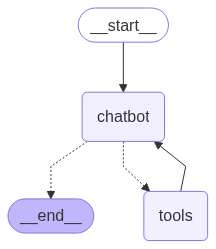

In [19]:
# LangGraph allows to visualize the graph with the get_graph method
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

##### As we can see we have the flow we want:

- We call the chatbot
- It can call a tool or give a response and END
- If the bot calls a tool the answer is returned to the bot
- This loop continues as long as the model decides to call tools
- If the model response is not a tool call, the flow is directed to the END, ending the process

## Now pick a thread to use, the thread will update the state of the graph allowing us to swap between chats by changing the thread_id

In [20]:
config = {"configurable": {"thread_id": "1"}}

In [ ]:
def stream_graph_updates(user_input: str):
    print("User:", user_input)  
    
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}, config):
        for value in event.values():
            
            if "messages" in value and value["messages"]:
                last_message = value["messages"][-1]

                if hasattr(last_message, 'content') and last_message.content:
                    print("Assistant:", last_message.content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: Hi, my name is Roberto
Assistant: Hi Roberto, it's nice to meet you! How can I help you today?
User: Do you remember my name ?
Assistant: Yes, your name is Roberto.
User: What can you tell me about alakazam
Assistant: 
User: What can you tell me about alakazam
Assistant: Alakazam is a psychic type Pokémon with 15 height and 480 weight.
User: What can you tell me about alakazam
Assistant: Alakazam is a psychic type Pokémon with 15 height and 480 weight.
User: What was the last question
Assistant: The last question you asked was "What can you tell me about alakazam".


c:\Proyectos\AgentsWithLangGraph\.venv\Lib\site-packages\langchain_google_genai\chat_models.py:1649: UserWarning: HumanMessage with empty content was removed to prevent API error
  warnings.warn(


User: 
Assistant: 
Goodbye!


#### As we can see now our chatbot now allow to talk about differente topics and remembers information by adding memory

#### Let's now see what happens if we change the thread_id

In [ ]:
config = {"configurable": {"thread_id": "2"}}

def stream_graph_updates(user_input: str):
    print("User:", user_input)  
    
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}, config):
        for value in event.values():
            
            if "messages" in value and value["messages"]:
                last_message = value["messages"][-1]

                if hasattr(last_message, 'content') and last_message.content:
                    print("Assistant:", last_message.content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: Hi
Assistant: Hi there! How can I help you today?
User: Do you remember my name ?
Assistant: As a large language model, I don't have memory of past conversations. So, no, I don't remember your name. You'll have to tell me!
Goodbye!


#### As we can see when changing the thread_id it does not remember anything from previous chats but by changing we could come back to the first chat and continue the conversation from last message